In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df_movie = pd.read_csv("data_movies_v3.csv")
df_movie.head()

index     budget                                    genres      id  \
0      0  237000000  Action Adventure Fantasy Science Fiction   19995   
1      1  300000000                  Adventure Fantasy Action     285   
2      2  245000000                    Action Adventure Crime  206647   
3      3  250000000               Action Crime Drama Thriller   49026   
4      4  260000000          Action Adventure Science Fiction   49529   

  original_language                                           overview  \
0                en  In the 22nd century, a paraplegic Marine is di...   
1                en  Captain Barbossa, long believed to be dead, ha...   
2                en  A cryptic message from Bond’s past sends him o...   
3                en  Following the death of District Attorney Harve...   
4                en  John Carter is a war-weary, former military ca...   

   popularity                               production_companies  \
0  150.437577  [{"name": "Ingenious Film Partners", "id": 289...   
1  139.082615  [{"name": "Walt Disney Pictures", "id": 2}, {"...   
2  107.376788  [{"name": "Columbia Pictures", "id": 5}, {"nam...   
3  112.312950  [{"name": "Legendary Pictures", "id": 923}, {"...   
4   43.926995        [{"name": "Walt Disney Pictures", "id": 2}]   

                                production_countries release_date     revenue  \
0  [{"iso_3166_1": "US", "name": "United States o...   2009-12-10  2787965087   
1  [{"iso_3166_1": "US", "name": "United States o...   2007-05-19   961000000   
2  [{"iso_3166_1": "GB", "name": "United Kingdom"...   2015-10-26   880674609   
3  [{"iso_3166_1": "US", "name": "United States o...   2012-07-16  1084939099   
4  [{"iso_3166_1": "US", "name": "United States o...   2012-03-07   284139100   

   runtime                                   spoken_languages    status  \
0    162.0  [{"iso_639_1": "en", "name": "English"}, {"iso...  Released   
1    169.0           [{"iso_639_1": "en", "name": "English"}]  Released   
2    148.0  [{"iso_639_1": "fr", "name": "Fran\u00e7ais"},...  Released   
3    165.0           [{"iso_639_1": "en", "name": "English"}]  Released   
4    132.0           [{"iso_639_1": "en", "name": "English"}]  Released   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   
2                           A Plan No One Escapes   
3                                 The Legend Ends   
4            Lost in our world, found in another.   

                                      title  vote_average  vote_count  \
0                                    Avatar           7.2       11800   
1  Pirates of the Caribbean: At World's End           6.9        4500   
2                                   Spectre           6.3        4466   
3                     The Dark Knight Rises           7.6        9106   
4                               John Carter           6.1        2124   

                                                cast  \
0  Sam Worthington Zoe Saldana Sigourney Weaver S...   
1  Johnny Depp Orlando Bloom Keira Knightley Stel...   
2  Daniel Craig Christoph Waltz L\u00e9a Seydoux ...   
3  Christian Bale Michael Caine Gary Oldman Anne ...   
4  Taylor Kitsch Lynn Collins Samantha Morton Wil...   

                                                crew           director  \
0  [{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...      James Cameron   
1  [{'name': 'Dariusz Wolski', 'gender': 2, 'depa...     Gore Verbinski   
2  [{'name': 'Thomas Newman', 'gender': 2, 'depar...         Sam Mendes   
3  [{'name': 'Hans Zimmer', 'gender': 2, 'departm...  Christopher Nolan   
4  [{'name': 'Andrew Stanton', 'gender': 2, 'depa...     Andrew Stanton   

   Drama  Comedy  Thriller  Action  Romance  Adventure  Crime  \
0      0       0         0       1        0          1      0   
1      0       0         0       1        0          1      0   
2      0       0         0     

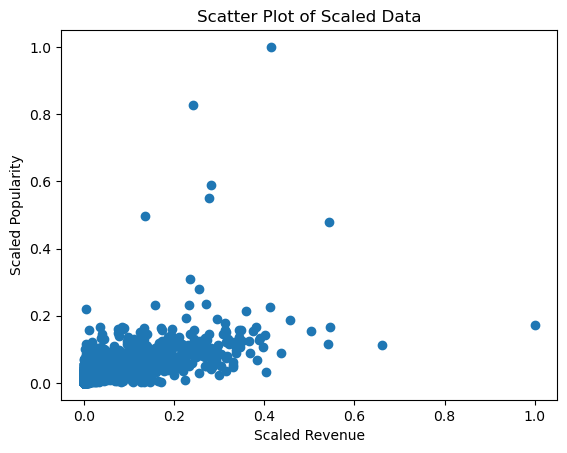

In [45]:
# Initialize the Min-Max scaler
scaler = MinMaxScaler()

# Scale the columns
df_movie[['revenue', 'popularity']] = scaler.fit_transform(df_movie[['revenue', 'popularity']])

# Create a scatter plot
plt.scatter(df_movie['revenue'], df_movie['popularity'])
plt.xlabel('Scaled Revenue')
plt.ylabel('Scaled Popularity')
plt.title('Scatter Plot of Scaled Data')
plt.show()

In [3]:
df_for_model = df_movie[(df_movie[['budget','popularity','revenue', 'runtime','vote_average', 'vote_count', 'sentiment','subjective']] != 0).all(axis=1)]
df_for_model = df_for_model.loc[:, ['budget','popularity','revenue', 'runtime','vote_average', 'vote_count','Drama','Comedy', 'Thriller', 'Action', 'Romance', 'Adventure', 'Crime','Science Fiction', 'Horror', 'Family', 'Fantasy', 'Mystery','Animation', 'History', 'Music', 'War', 'Documentary', 'Western','Foreign', 'num_of_production_companies', 'sentiment','subjective']]


In [4]:
df_for_model.head()

budget  popularity     revenue  runtime  vote_average  vote_count  \
0  237000000  150.437577  2787965087    162.0           7.2       11800   
1  300000000  139.082615   961000000    169.0           6.9        4500   
2  245000000  107.376788   880674609    148.0           6.3        4466   
3  250000000  112.312950  1084939099    165.0           7.6        9106   
4  260000000   43.926995   284139100    132.0           6.1        2124   

   Drama  Comedy  Thriller  Action  Romance  Adventure  Crime  \
0      0       0         0       1        0          1      0   
1      0       0         0       1        0          1      0   
2      0       0         0       1        0          1      1   
3      1       0         1       1        0          0      1   
4      0       0         0       1        0          1      0   

   Science Fiction  Horror  Family  Fantasy  Mystery  Animation  History  \
0                1       0       0        1        0          0        0   
1                0       0       0        1        0          0        0   
2                0       0       0        0        0          0        0   
3                0       0       0        0        0          0        0   
4                1       0       0        0        0          0        0   

   Music  War  Documentary  Western  Foreign  num_of_production_companies  \
0      0    0            0        0        0                            4   
1      0    0            0        0        0                            3   
2      0    0            0        0        0                            3   
3      0    0            0        0        0                            4   
4      0    0            0        0        0                            1   

   sentiment  subjective  
0   0.041667    0.616667  
1  -0.083333    0.266667  
2  -0.306250    0.518750  
3  -0.044805    0.372078  
4  -0.016667    0.566667

In [ ]:
#Here we categorize popularity into three classes low, average and high represented by 0, 1 and 2

In [40]:
# Define the popularity categories
popularity_bins = [-1, 50, 100, float('inf')]
popularity_labels = [0, 1, 2]

# Convert the "popularity" column into categories
df_for_model['popularity'] = pd.cut(df_for_model['popularity'], bins=popularity_bins, labels=popularity_labels)

In [ ]:
#Here we categorize movie into three classes hit, average and miss represented by 2, 1 and 0

In [ ]:
# Define the conditions and assign values to "hit_average_miss"
df_for_model['hit_average_miss'] = 0  # Initialize with a default value
df_for_model.loc[df_for_model['revenue'] >= 2 * df_for_model['budget'], 'hit_average_miss'] = 2
df_for_model.loc[(df_for_model['budget'] <= df_for_model['revenue']) & (df_for_model['revenue'] < 2 * df_for_model['budget']), 'hit_average_miss'] = 1


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


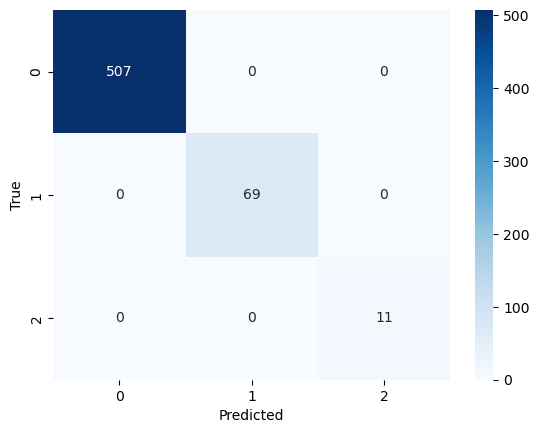

In [41]:
#Sanity Check
X= df_for_model
y = df_for_model['popularity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optional: Scale input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

By Running our code on all the features(including the output feature), we got 100% accuracy, which means that our preprocessing is fine and model is working.

In [32]:
X = df_for_model.drop(['popularity','revenue'], axis=1)
y = df_for_model['popularity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optional: Scale input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [37]:
X

budget  runtime  vote_average  vote_count  Drama  Comedy  Thriller  \
0     237000000    162.0           7.2       11800      0       0         0   
1     300000000    169.0           6.9        4500      0       0         0   
2     245000000    148.0           6.3        4466      0       0         0   
3     250000000    165.0           7.6        9106      1       0         1   
4     260000000    132.0           6.1        2124      0       0         0   
5     258000000    139.0           5.9        3576      0       0         0   
6     260000000    100.0           7.4        3330      0       0         0   
7     280000000    141.0           7.3        6767      0       0         0   
8     250000000    153.0           7.4        5293      0       0         0   
9     250000000    151.0           5.7        7004      0       0         0   
10    270000000    154.0           5.4        1400      0       0         0   
11    200000000    106.0           6.1        2965      0       0         1   
13    255000000    149.0           5.9        2311      0       0         0   
14    225000000    143.0           6.5        6359      0       0         0   
15    225000000    150.0           6.3        1630      0       0         0   
16    220000000    143.0           7.4       11776      0       0         0   
17    380000000    136.0           6.4        4948      0       0         0   
18    225000000    106.0           6.2        4160      0       1         0   
19    250000000    144.0           7.1        4760      0       0         0   
20    215000000    136.0           6.5        6586      0       0         0   
22    250000000    161.0           7.6        4524      0       0         0   
23    180000000    113.0           5.8        1303      0       0         0   
24    207000000    187.0           6.6        2337      1       0         0   
25    200000000    194.0           7.5        7562      1       0         1   
26    250000000    147.0           7.1        7241      0       0         0   
27    209000000    131.0           5.5        2114      0       0         1   
28    150000000    124.0           6.5        8662      0       0         1   
29    200000000    143.0           6.9        7604      0       0         1   
30    200000000    127.0           6.7        4321      0       0         0   
31    200000000    130.0           6.8        8806      0       0         0   
32    200000000    108.0           6.4        4645      0       0         0   
33    210000000    104.0           6.3        3525      0       0         1   
34    200000000    104.0           7.0        3528      0       0         0   
35    150000000    150.0           6.0        3138      0       0         0   
36    210000000    165.0           5.8        3095      0       0         0   
37    200000000    130.0           5.7        3530      0       0         0   
38    200000000    142.0           6.5        4179      0       0         0   
39    170000000    125.0           6.3        2841      0       0         0   
40    200000000    106.0           5.8        2033      0       1         0   
41    200000000    114.0           5.1        2487      0       0         1   
42    200000000    103.0           7.6        4597      0       1         0   
43    200000000    115.0           5.9        2463      0       0         1   
45    200000000    116.0           6.7        5560      1       0         1   
46    250000000    131.0           7.5        6032      0       0         0   
47    190000000    132.0           7.4        4418      0       0         0   
48    195000000    114.0           5.5        2598      0       0         0   
49    105000000    143.0           7.3        3769      1       0         0   
50    150000000    116.0           6.2        2317      0       0         0   
51    180000000    131.0           6.7        4794      0       0         0   
52    195000000    154.0           6.1        3299      0  

Accuracy: 0.909710391822828
Precision: 0.9050572481280457
Recall: 0.909710391822828
F1 Score: 0.9069718645396211


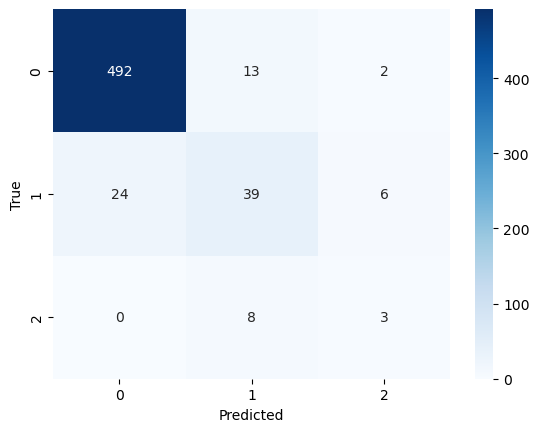

In [33]:
# Create and train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy: 0.8977853492333902
Precision: 0.8989961351739477
Recall: 0.8977853492333902
F1 Score: 0.8982376797431707


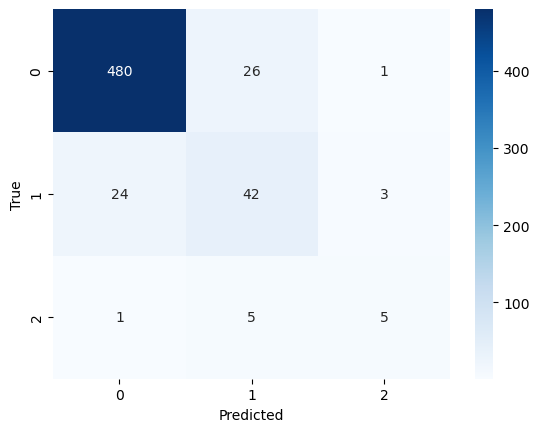

In [34]:
# Create and train the XGBoost classifier
model = XGBClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [46]:
#Here we categorize movie into three classes hit, average and miss represented by 2, 1 and 0

In [47]:
# Define the conditions and assign values to "hit_average_miss"
df_for_model['hit_average_miss'] = 0  # Initialize with a default value
df_for_model.loc[df_for_model['revenue'] >= 2 * df_for_model['budget'], 'hit_average_miss'] = 2
df_for_model.loc[(df_for_model['budget'] <= df_for_model['revenue']) & (df_for_model['revenue'] < 2 * df_for_model['budget']), 'hit_average_miss'] = 1

In [59]:
# X = df_for_model.drop(['popularity','revenue','hit_average_miss'], axis=1)
X = df_for_model.drop(['revenue','hit_average_miss'], axis=1)
y = df_for_model['hit_average_miss']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optional: Scale input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [60]:
X

budget popularity  runtime  vote_average  vote_count  Drama  Comedy  \
0     237000000          2    162.0           7.2       11800      0       0   
1     300000000          2    169.0           6.9        4500      0       0   
2     245000000          2    148.0           6.3        4466      0       0   
3     250000000          2    165.0           7.6        9106      1       0   
4     260000000          0    132.0           6.1        2124      0       0   
5     258000000          2    139.0           5.9        3576      0       0   
6     260000000          0    100.0           7.4        3330      0       0   
7     280000000          2    141.0           7.3        6767      0       0   
8     250000000          1    153.0           7.4        5293      0       0   
9     250000000          2    151.0           5.7        7004      0       0   
10    270000000          1    154.0           5.4        1400      0       0   
11    200000000          2    106.0           6.1        2965      0       0   
13    255000000          0    149.0           5.9        2311      0       0   
14    225000000          1    143.0           6.5        6359      0       0   
15    225000000          1    150.0           6.3        1630      0       0   
16    220000000          2    143.0           7.4       11776      0       0   
17    380000000          2    136.0           6.4        4948      0       0   
18    225000000          1    106.0           6.2        4160      0       1   
19    250000000          2    144.0           7.1        4760      0       0   
20    215000000          1    136.0           6.5        6586      0       0   
22    250000000          1    161.0           7.6        4524      0       0   
23    180000000          0    113.0           5.8        1303      0       0   
24    207000000          1    187.0           6.6        2337      1       0   
25    200000000          2    194.0           7.5        7562      1       0   
26    250000000          2    147.0           7.1        7241      0       0   
27    209000000          1    131.0           5.5        2114      0       0   
28    150000000          2    124.0           6.5        8662      0       0   
29    200000000          1    143.0           6.9        7604      0       0   
30    200000000          0    127.0           6.7        4321      0       0   
31    200000000          1    130.0           6.8        8806      0       0   
32    200000000          1    108.0           6.4        4645      0       0   
33    210000000          0    104.0           6.3        3525      0       0   
34    200000000          1    104.0           7.0        3528      0       0   
35    150000000          0    150.0           6.0        3138      0       0   
36    210000000          2    165.0           5.8        3095      0       0   
37    200000000          0    130.0           5.7        3530      0       0   
38    200000000          1    142.0           6.5        4179      0       0   
39    170000000          1    125.0           6.3        2841      0       0   
40    200000000          0    106.0           5.8        2033      0       1   
41    200000000          1    114.0           5.1        2487      0       0   
42    200000000          1    103.0           7.6        4597      0       1   
43    200000000          1    115.0           5.9        2463      0       0   
45    200000000          1    116.0           6.7        5560      1       0   
46    250000000          2    131.0           7.5        6032      0       0   
47    190000000          1    132.0           7.4        4418      0       0   
48    195000000          0    114.0           5.5        2598      0       0   
49    105000000          1    143.0           7.3        3769      1       0   
50    150000000          1    116.0           6.2        2317      0       0   
51    180000000          1    131.0           6.7        4794      0       0   
52    195

Accuracy: 0.6303236797274276
Precision: 0.6014402506310779
Recall: 0.6303236797274276
F1 Score: 0.5816649530028842


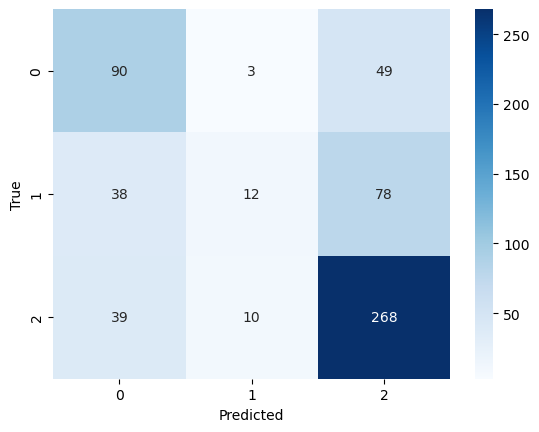

In [61]:
# Create and train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [62]:
# Create and train the XGBoost classifier
model = XGBClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy: 0.606473594548552
Precision: 0.5763653007088977
Recall: 0.606473594548552
F1 Score: 0.5850402525033332


# Model: K-Means Clustering

# Euclidean Distance calculated on original data with over 25 dimensions; Later the data and centroids are reduced using PCA to 2 dimensions for visualization

In [24]:
X = df_for_model.drop(['revenue','popularity','vote_average'], axis=1)
kmeans_cluster = KMeans(init = "random",n_clusters = 3,n_init = 50,random_state = 0) 
kmeans_cluster.fit(X)
centroids = kmeans_cluster.cluster_centers_

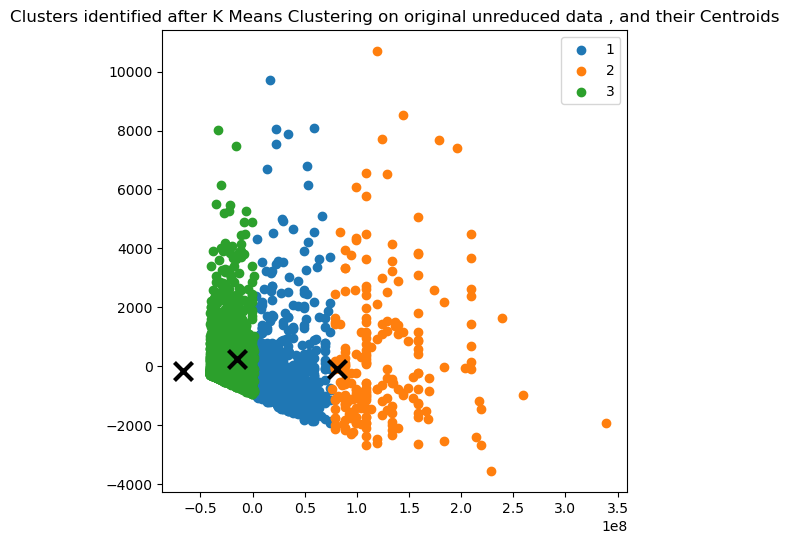

In [25]:
pca = PCA(2)
reduced_X = pca.fit_transform(X)
kmc_predictions = kmeans_cluster.fit_predict(X)

reduced_centroids = pca.fit_transform(centroids)


plt.figure(figsize=(6, 6))
plt.title("Clusters identified after K Means Clustering on original unreduced data , and their Centroids")
for i in range(3):
    plt.scatter(reduced_X[kmc_predictions == i, 0],
                reduced_X[kmc_predictions == i, 1],
                label=i+1)
plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='k', zorder=10)

plt.legend()
plt.show()

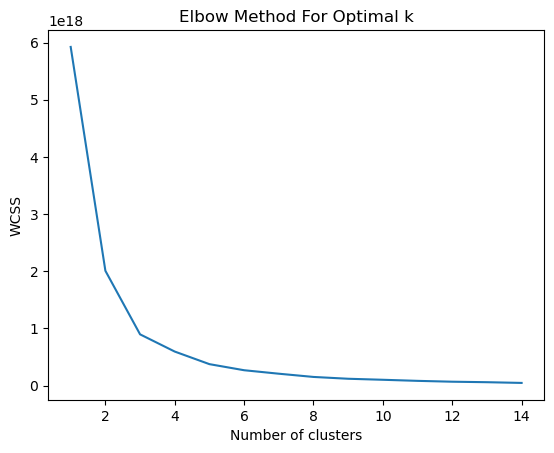

In [26]:
wcss = []
for i in range(1, 15):
    kmeans_cluster = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans_cluster.fit(X)
    wcss.append(kmeans_cluster.inertia_)
plt.figure()
plt.plot(range(1, 15), wcss)
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow_method.png')
plt.show()

In [19]:
np.unique(kmc_predictions)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
      dtype=int32)